In [1]:
#Using variable length sequences when seleframe > 11
#could augmentation validation data
#fixed size validation sequences 
#fine tuning the select frames and batch size 

In [2]:
import os
import time
import scipy.io as io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions_M import *
from DataAugFlipPad import * #padding to fixed length training sequences with flipping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

In [3]:
# set path
datapaths = "../SMIC/SMIC_all_cropped/HS/*/"   # define UCF-101 RGB data path
Logpath = "Log"
action_names = ['negative', 'positive','surprise','non_micro-expression']
save_model_path = "./VGG_LSTM/"

In [4]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.0       # dropout probability

# DecoderRNN architecture
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

# training parameters
k = 5
clas = 4             # number of target category
epochs = 20     # training epochs

batch_vali = 1
log_interval = 30   # interval for displaying training info

# Select which frame to begin & end in videos

step = 1
item = 1
#validation parameters
valid_loss_sum = 0
valid_score_sum = 0

#freezing layers for VGGFace2 model
features_layers = 91
train_list2 = []
train_label2 = []

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use CPU or GPU

In [5]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    
    N_count = 0   # counting total trained sample in one epoch

    for batch_idx, (X1, X2, y) in enumerate(train_loader):
        # distribute data to device
        X1, X2, y = X1.to(device), X2.to(device), y.to(device).view(-1, )
        
        N_count += X1.size(0)
        
        optimizer.zero_grad()
        
        output1 = rnn_decoder(cnn_encoder(X1))   # output has dim = (batch, number of classes)
        output2 = rnn_decoder(cnn_encoder(X2)) 

        loss = F.cross_entropy(output1, y)
        losses.append(loss.item())
        loss = F.cross_entropy(output2, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output1, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU
        # to compute accuracy
        y_pred = torch.max(output2, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score) 

        loss.backward()
        optimizer.step()

        # show information
#         if (batch_idx + 1) % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
#                 epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores

In [6]:
def test(model, device, optimizer, test_loader, epoch):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()
    nb_classes = 4

    test_loss = 0
    all_y = []   
    all_y_pred = []
    with torch.no_grad():
        for X1, X2, y in test_loader:
            # distribute data to device
            X1, X2, y = X1.to(device), X2.to(device), y.to(device).view(-1, )

            output1 = rnn_decoder(cnn_encoder(X1))
            output2 = rnn_decoder(cnn_encoder(X2))
            
            loss = F.cross_entropy(output1, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            loss = F.cross_entropy(output2, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            # (y_pred != output) get the index of the max log-probability      
            y_pred = output1.max(1, keepdim=True)[1] 
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)*2
    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), \
                                                                test_loss, 100* test_score))

    # save Pytorch models of best record
    torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))
    
    return test_loss, test_score

In [7]:
def validation(model, device, vali_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()
    nb_classes = 4
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, X2, y in vali_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = rnn_decoder(cnn_encoder(X))
            
            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()  # sum up batch loss
            
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability
            for t, p in zip(y.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1 # get the prediction value and lable value
            
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(vali_loader.dataset)
    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    #print out confusion matrix
    print(confusion_matrix)
    # show information
    print('\nValid set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    return test_loss, test_score, confusion_matrix

In [8]:
#Freeze layers before classifier
def freezing(model, features_layers):
    lay_mark = 0;
    para_list = []
    for param in model.parameters():
        if lay_mark > features_layers:
            para_list.append(param)
        if lay_mark <= features_layers:
            param.requires_grad = False
        lay_mark += 1
    return model, para_list

In [9]:
#Allocating 5 groups for cross-validation and training
Val_tra_tes_list = CrossAllocation(datapaths,k)

#Set transformation
tran_t = transforms.Compose(
    [transforms.Resize([224,224]), 
     transforms.ToTensor(),     
    ])

In [10]:
def mkdir(Logpath):
    folder = os.path.exists(Logpath)
    if not folder:
        os.makedirs(Logpath)
        print("create new folder")

    localtime = time.asctime(time.localtime(time.time()))
    
    #set recording log title
    title = 'Final Fine-tuning 3-Layer LSTM'
    file = open(Logpath+'/'+title+'.txt','w')    
    file.write('Created on {}, by Keira.Bai\n'.format(localtime))
    file.write('Completed VGGFace2\n')
    file.write('No SoftMax\n')
    file.write('{} layersLSTM\t {} hidden nodes\n'.format(RNN_hidden_layers,RNN_hidden_nodes))

    file.close()  
    
    return title

In [11]:
#Packaging Data
def PackData(val,k, seleframe, params, params_vali,title):
    #get validation list and label
    valid_list, valid_label, val_expCount = RawforVal(val) #InputImageforVal(val, seleframe)
  
    #get train&test list and label
    tra_tes_list = np.delete(Val_tra_tes_list,v,axis = 0)  
    train_test_list, train_test_label, expCount = InputImagewithSlide(tra_tes_list, seleframe)#get training and testing data

    #test and train dataset split, data loader
    train_list, test_list, train_label, test_label = train_test_split(train_test_list, train_test_label, \
                                      test_size=1/k, random_state=42)
    train_set, test_set, valid_set = MicroExpDataset(train_list, train_label, tran_t=tran_t), \
                                    MicroExpDataset(test_list, test_label, tran_t=tran_t), \
                                    MicroExpDataset(valid_list, valid_label, tran_t=tran_t)    
    
#     file = open(Logpath+'/'+title+'.txt','a')
#     file.write("Amount of each expression before augmentation:{}\n".format(expCount[:4]))
#     file.write("Amount of each expression after augmentation:{}\n".format(expCount[4:]))
#     file.close()
    
    train_loader = data.DataLoader(train_set, **params)
    test_loader = data.DataLoader(test_set, **params)
    valid_loader = data.DataLoader(valid_set, **params_vali)
    train_len = len(train_set)*2
    
    return train_loader, test_loader, valid_loader, train_len

In [12]:
def DrawPlot(v,A,B,C,D):
    # plot
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
    plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
    plt.title("model loss")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc="upper left")
    # 2nd figure
    plt.subplot(122)
    plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
    plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
    plt.title("training scores")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc="upper left")
    title = "./fig_"+str(v)+".png"
    plt.savefig(title, dpi=600)
    # plt.close(fig)
    plt.show()

In [13]:
#start record Log
def TrainingModel(v,seleframe, batch_size, lr, title, params, params_vali,item):
    
    #get validation groups
    val = Val_tra_tes_list[v]

    train_loader, test_loader, valid_loader, train_len = PackData(val,k,seleframe, params, params_vali,title)
  
    # Create model
    cnn_encoder = VggFaceEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, 
                                 CNN_embed_dim=CNN_embed_dim).to(device)
    rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                             h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=clas).to(device)
    cnn_encoder, para_list = freezing(cnn_encoder, features_layers)
    cnn_encoder = cnn_encoder.to(device)
  
    #set parameters
    crnn_params = para_list + list(rnn_decoder.parameters())
    optimizer = torch.optim.Adam(crnn_params, lr)

    # record training process
    epoch_train_losses = []
    epoch_train_scores = []
    epoch_test_losses = []
    epoch_test_scores = []
    epoch_confusion_matrix = []
    
    #start training
    for epoch in range(epochs):
        print("Epoch:", epoch)
        #train,test model
        train_losses, train_scores = train(log_interval, [cnn_encoder, rnn_decoder], \
                                           device, train_loader, optimizer, epoch)
        epoch_test_loss, epoch_test_score = test([cnn_encoder, rnn_decoder], device, \
                                                 optimizer, test_loader, epoch)

        # save results
        epoch_train_losses.append(train_losses)
        epoch_train_scores.append(train_scores)
        epoch_test_losses.append(epoch_test_loss)
        epoch_test_scores.append(epoch_test_score)

        # save all train test results
        A = np.array(epoch_train_losses)
        B = np.array(epoch_train_scores)
        C = np.array(epoch_test_losses)
        D = np.array(epoch_test_scores)
    #training end  
    
    #draw plot
    DrawPlot(v,A,B,C,D)
    #validate model
    valid_loss, valid_score, valid_confusion_matrix = validation([cnn_encoder, rnn_decoder], device, valid_loader)

    file = open(Logpath+'/'+title+'.txt','a')
    file.write('\n')
    file.write("-"*60)
    file.write('\n')
    file.write("Group:"+str(v)+'\t')
    file.write('Accuracy: {:.2f}%\n'.format(valid_score*100))
    file.write('Validation loss: {:.4f}\n'.format(valid_loss))    
    file.write('select frame\tbatch_size\t\learning Rate\n')#table title
    file.write('{}\t\t{}\t\t{}\n'.format(seleframe, batch_size, lr))
    
    for i in valid_confusion_matrix:
        file.write(str(i)[6:])
        file.write("\n")
    file.write("\n")
    file.close()

    return valid_score

Epoch: 0

Test set (1426 samples): Average loss: 1.0390, Accuracy: 49.65%

Epoch 1 model saved!
Epoch: 1

Test set (1426 samples): Average loss: 0.9453, Accuracy: 57.92%

Epoch 2 model saved!
Epoch: 2

Test set (1426 samples): Average loss: 0.7709, Accuracy: 68.30%

Epoch 3 model saved!
Epoch: 3

Test set (1426 samples): Average loss: 0.7868, Accuracy: 64.80%

Epoch 4 model saved!
Epoch: 4

Test set (1426 samples): Average loss: 0.4123, Accuracy: 81.84%

Epoch 5 model saved!
Epoch: 5

Test set (1426 samples): Average loss: 0.4413, Accuracy: 82.12%

Epoch 6 model saved!
Epoch: 6

Test set (1426 samples): Average loss: 0.4474, Accuracy: 79.24%

Epoch 7 model saved!
Epoch: 7

Test set (1426 samples): Average loss: 0.4870, Accuracy: 79.38%

Epoch 8 model saved!
Epoch: 8

Test set (1426 samples): Average loss: 0.4439, Accuracy: 84.36%

Epoch 9 model saved!
Epoch: 9

Test set (1426 samples): Average loss: 0.3478, Accuracy: 83.59%

Epoch 10 model saved!
Epoch: 10

Test set (1426 samples): Ave

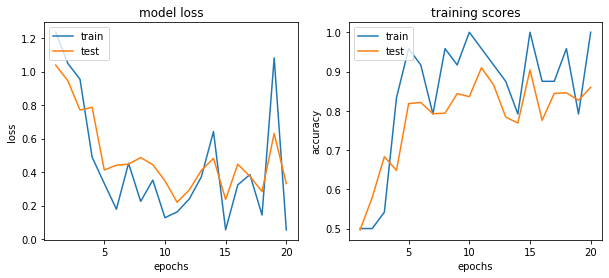

tensor([[ 3.,  4.,  0.,  7.],
        [ 5.,  3.,  0.,  6.],
        [ 1.,  0.,  1.,  4.],
        [10.,  0.,  2., 20.]])

Valid set (66 samples): Average loss: 2.4311, Accuracy: 40.91%

Epoch: 0

Test set (1442 samples): Average loss: 1.3062, Accuracy: 35.78%

Epoch 1 model saved!
Epoch: 1

Test set (1442 samples): Average loss: 1.0191, Accuracy: 52.15%

Epoch 2 model saved!
Epoch: 2

Test set (1442 samples): Average loss: 0.9199, Accuracy: 59.85%

Epoch 3 model saved!
Epoch: 3

Test set (1442 samples): Average loss: 1.1644, Accuracy: 51.25%

Epoch 4 model saved!
Epoch: 4

Test set (1442 samples): Average loss: 0.9199, Accuracy: 54.79%

Epoch 5 model saved!
Epoch: 5

Test set (1442 samples): Average loss: 0.7402, Accuracy: 67.75%

Epoch 6 model saved!
Epoch: 6

Test set (1442 samples): Average loss: 1.0510, Accuracy: 60.61%

Epoch 7 model saved!
Epoch: 7

Test set (1442 samples): Average loss: 0.7597, Accuracy: 62.90%

Epoch 8 model saved!
Epoch: 8

Test set (1442 samples): Average los

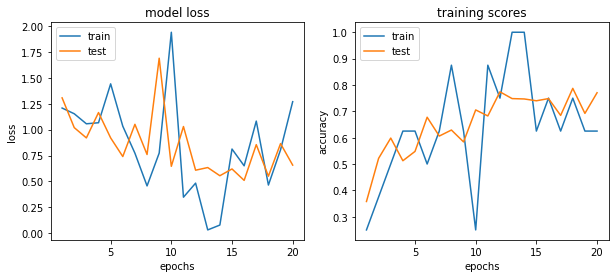

tensor([[12.,  2.,  0.,  3.],
        [ 1.,  5.,  0.,  2.],
        [ 2.,  0.,  2.,  2.],
        [13.,  2.,  0., 20.]])

Valid set (66 samples): Average loss: 1.5206, Accuracy: 59.09%

Epoch: 0

Test set (1442 samples): Average loss: 1.3366, Accuracy: 29.13%

Epoch 1 model saved!
Epoch: 1

Test set (1442 samples): Average loss: 1.1426, Accuracy: 42.44%

Epoch 2 model saved!
Epoch: 2

Test set (1442 samples): Average loss: 1.1641, Accuracy: 47.78%

Epoch 3 model saved!
Epoch: 3

Test set (1442 samples): Average loss: 1.0875, Accuracy: 45.21%

Epoch 4 model saved!
Epoch: 4

Test set (1442 samples): Average loss: 1.0902, Accuracy: 43.62%

Epoch 5 model saved!
Epoch: 5

Test set (1442 samples): Average loss: 1.0050, Accuracy: 56.10%

Epoch 6 model saved!
Epoch: 6

Test set (1442 samples): Average loss: 1.1311, Accuracy: 51.11%

Epoch 7 model saved!
Epoch: 7

Test set (1442 samples): Average loss: 1.0464, Accuracy: 51.18%

Epoch 8 model saved!
Epoch: 8

Test set (1442 samples): Average los

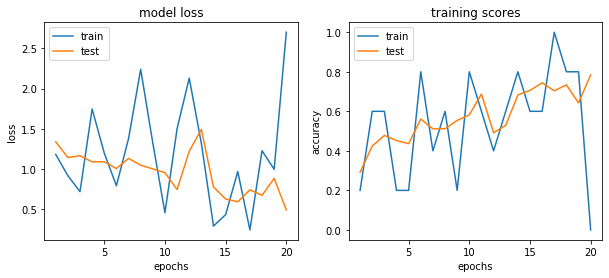

tensor([[ 4.,  8.,  1.,  3.],
        [ 1.,  6.,  0.,  2.],
        [ 4.,  1.,  4.,  4.],
        [ 9., 10.,  2.,  7.]])

Valid set (66 samples): Average loss: 2.7645, Accuracy: 31.82%

Epoch: 0

Test set (1510 samples): Average loss: 1.2952, Accuracy: 37.95%

Epoch 1 model saved!
Epoch: 1

Test set (1510 samples): Average loss: 1.0763, Accuracy: 52.32%

Epoch 2 model saved!
Epoch: 2

Test set (1510 samples): Average loss: 0.8757, Accuracy: 60.53%

Epoch 3 model saved!
Epoch: 3

Test set (1510 samples): Average loss: 0.7784, Accuracy: 64.50%

Epoch 4 model saved!
Epoch: 4

Test set (1510 samples): Average loss: 0.6775, Accuracy: 66.09%

Epoch 5 model saved!
Epoch: 5

Test set (1510 samples): Average loss: 0.6684, Accuracy: 67.42%

Epoch 6 model saved!
Epoch: 6

Test set (1510 samples): Average loss: 0.7123, Accuracy: 69.54%

Epoch 7 model saved!
Epoch: 7

Test set (1510 samples): Average loss: 0.6879, Accuracy: 72.65%

Epoch 8 model saved!
Epoch: 8

Test set (1510 samples): Average los

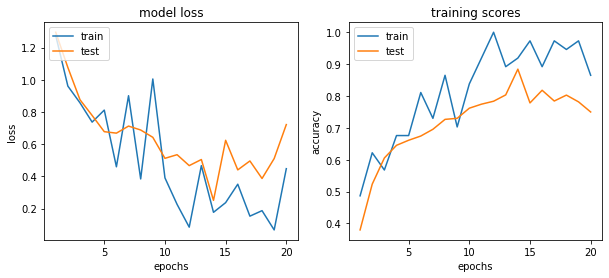

tensor([[ 2.,  2.,  2.,  5.],
        [ 1.,  4.,  0.,  2.],
        [ 2.,  1.,  6.,  2.],
        [ 7.,  5.,  3., 21.]])

Valid set (65 samples): Average loss: 2.8117, Accuracy: 50.77%

Epoch: 0

Test set (1460 samples): Average loss: 0.9849, Accuracy: 60.14%

Epoch 1 model saved!
Epoch: 1

Test set (1460 samples): Average loss: 0.8508, Accuracy: 62.12%

Epoch 2 model saved!
Epoch: 2

Test set (1460 samples): Average loss: 0.7553, Accuracy: 66.92%

Epoch 3 model saved!
Epoch: 3

Test set (1460 samples): Average loss: 0.7659, Accuracy: 66.78%

Epoch 4 model saved!
Epoch: 4

Test set (1460 samples): Average loss: 0.6657, Accuracy: 70.89%

Epoch 5 model saved!
Epoch: 5

Test set (1460 samples): Average loss: 0.7053, Accuracy: 67.67%

Epoch 6 model saved!
Epoch: 6

Test set (1460 samples): Average loss: 0.6559, Accuracy: 72.05%

Epoch 7 model saved!
Epoch: 7

Test set (1460 samples): Average loss: 0.5855, Accuracy: 74.59%

Epoch 8 model saved!
Epoch: 8

Test set (1460 samples): Average los

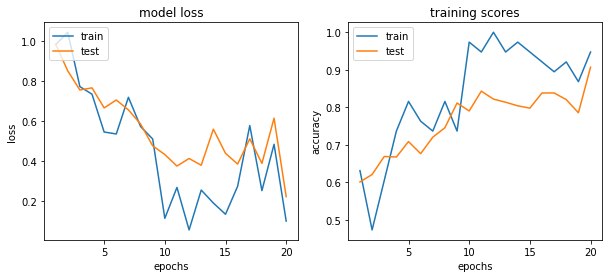

tensor([[ 2.,  4.,  2.,  4.],
        [ 4.,  6.,  1.,  2.],
        [ 1.,  1.,  4.,  1.],
        [ 4.,  6.,  5., 18.]])

Valid set (65 samples): Average loss: 2.4518, Accuracy: 46.15%

Epoch: 0

Test set (1128 samples): Average loss: 1.2831, Accuracy: 42.91%

Epoch 1 model saved!
Epoch: 1

Test set (1128 samples): Average loss: 1.2379, Accuracy: 43.17%

Epoch 2 model saved!
Epoch: 2

Test set (1128 samples): Average loss: 1.2671, Accuracy: 36.26%

Epoch 3 model saved!
Epoch: 3

Test set (1128 samples): Average loss: 1.2601, Accuracy: 41.05%

Epoch 4 model saved!
Epoch: 4

Test set (1128 samples): Average loss: 1.2047, Accuracy: 44.68%

Epoch 5 model saved!
Epoch: 5

Test set (1128 samples): Average loss: 1.1293, Accuracy: 48.05%

Epoch 6 model saved!
Epoch: 6

Test set (1128 samples): Average loss: 1.1645, Accuracy: 48.05%

Epoch 7 model saved!
Epoch: 7

Test set (1128 samples): Average loss: 1.0862, Accuracy: 52.30%

Epoch 8 model saved!
Epoch: 8

Test set (1128 samples): Average los

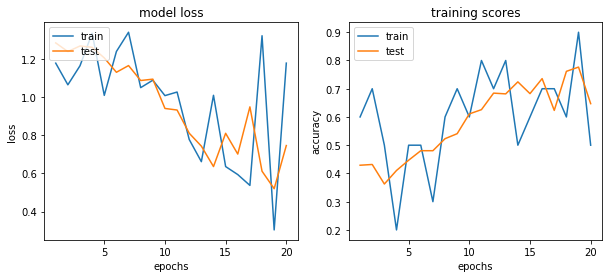

tensor([[ 8.,  1.,  0.,  5.],
        [ 4.,  7.,  1.,  2.],
        [ 3.,  0.,  2.,  1.],
        [21.,  1.,  2.,  8.]])

Valid set (66 samples): Average loss: 1.4186, Accuracy: 37.88%

Epoch: 0

Test set (1140 samples): Average loss: 1.2587, Accuracy: 37.63%

Epoch 1 model saved!
Epoch: 1

Test set (1140 samples): Average loss: 1.2433, Accuracy: 37.37%

Epoch 2 model saved!
Epoch: 2

Test set (1140 samples): Average loss: 1.0906, Accuracy: 51.32%

Epoch 3 model saved!
Epoch: 3

Test set (1140 samples): Average loss: 1.0621, Accuracy: 50.79%

Epoch 4 model saved!
Epoch: 4

Test set (1140 samples): Average loss: 1.0346, Accuracy: 53.77%

Epoch 5 model saved!
Epoch: 5

Test set (1140 samples): Average loss: 1.0798, Accuracy: 53.95%

Epoch 6 model saved!
Epoch: 6

Test set (1140 samples): Average loss: 0.9817, Accuracy: 54.56%

Epoch 7 model saved!
Epoch: 7

Test set (1140 samples): Average loss: 0.8557, Accuracy: 61.93%

Epoch 8 model saved!
Epoch: 8

Test set (1140 samples): Average los

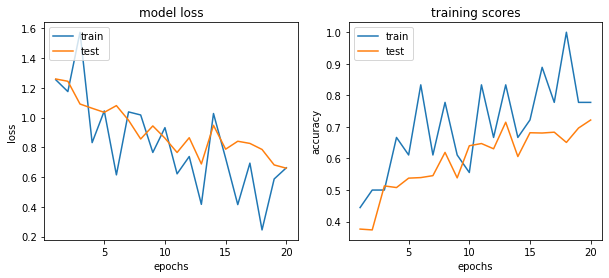

tensor([[13.,  0.,  0.,  4.],
        [ 5.,  3.,  0.,  0.],
        [ 3.,  0.,  1.,  2.],
        [22.,  2.,  5.,  6.]])

Valid set (66 samples): Average loss: 1.3380, Accuracy: 34.85%

Epoch: 0

Test set (1143 samples): Average loss: 1.1964, Accuracy: 45.76%

Epoch 1 model saved!
Epoch: 1

Test set (1143 samples): Average loss: 1.1435, Accuracy: 46.72%

Epoch 2 model saved!
Epoch: 2

Test set (1143 samples): Average loss: 1.1348, Accuracy: 46.81%

Epoch 3 model saved!
Epoch: 3

Test set (1143 samples): Average loss: 1.1164, Accuracy: 43.22%

Epoch 4 model saved!
Epoch: 4

Test set (1143 samples): Average loss: 1.0956, Accuracy: 45.67%

Epoch 5 model saved!
Epoch: 5

Test set (1143 samples): Average loss: 1.1212, Accuracy: 47.94%

Epoch 6 model saved!
Epoch: 6

Test set (1143 samples): Average loss: 1.0313, Accuracy: 48.82%

Epoch 7 model saved!
Epoch: 7

Test set (1143 samples): Average loss: 1.2776, Accuracy: 48.91%

Epoch 8 model saved!
Epoch: 8

Test set (1143 samples): Average los

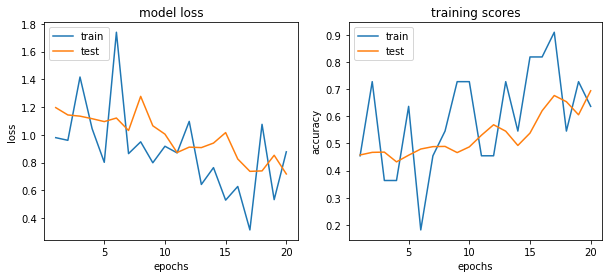

tensor([[ 6.,  3.,  6.,  1.],
        [ 3.,  3.,  1.,  2.],
        [ 5.,  0.,  7.,  1.],
        [13.,  3.,  7.,  5.]])

Valid set (66 samples): Average loss: 1.8995, Accuracy: 31.82%

Epoch: 0

Test set (1197 samples): Average loss: 1.2310, Accuracy: 48.79%

Epoch 1 model saved!
Epoch: 1

Test set (1197 samples): Average loss: 1.1718, Accuracy: 48.20%

Epoch 2 model saved!
Epoch: 2

Test set (1197 samples): Average loss: 1.1181, Accuracy: 52.63%

Epoch 3 model saved!
Epoch: 3

Test set (1197 samples): Average loss: 1.2042, Accuracy: 52.46%

Epoch 4 model saved!
Epoch: 4

Test set (1197 samples): Average loss: 1.0901, Accuracy: 49.79%

Epoch 5 model saved!
Epoch: 5

Test set (1197 samples): Average loss: 1.0662, Accuracy: 55.30%

Epoch 6 model saved!
Epoch: 6

Test set (1197 samples): Average loss: 1.1669, Accuracy: 53.13%

Epoch 7 model saved!
Epoch: 7

Test set (1197 samples): Average loss: 1.0781, Accuracy: 52.88%

Epoch 8 model saved!
Epoch: 8

Test set (1197 samples): Average los

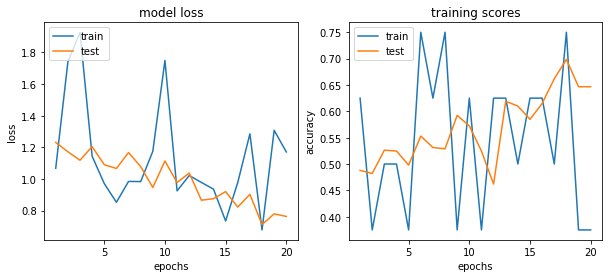

tensor([[ 1.,  0.,  1.,  9.],
        [ 0.,  4.,  0.,  3.],
        [ 1.,  0.,  4.,  6.],
        [ 7.,  0.,  3., 26.]])

Valid set (65 samples): Average loss: 1.4180, Accuracy: 53.85%

Epoch: 0

Test set (1154 samples): Average loss: 1.1986, Accuracy: 39.60%

Epoch 1 model saved!
Epoch: 1

Test set (1154 samples): Average loss: 1.1173, Accuracy: 46.45%

Epoch 2 model saved!
Epoch: 2

Test set (1154 samples): Average loss: 1.1410, Accuracy: 45.32%

Epoch 3 model saved!
Epoch: 3

Test set (1154 samples): Average loss: 1.0875, Accuracy: 48.27%

Epoch 4 model saved!
Epoch: 4

Test set (1154 samples): Average loss: 1.0355, Accuracy: 50.35%

Epoch 5 model saved!
Epoch: 5

Test set (1154 samples): Average loss: 1.0845, Accuracy: 51.65%

Epoch 6 model saved!
Epoch: 6

Test set (1154 samples): Average loss: 1.0022, Accuracy: 45.58%

Epoch 7 model saved!
Epoch: 7

Test set (1154 samples): Average loss: 1.0898, Accuracy: 40.99%

Epoch 8 model saved!
Epoch: 8

Test set (1154 samples): Average los

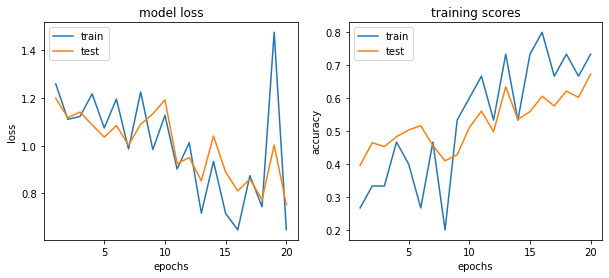

tensor([[ 5.,  6.,  1.,  0.],
        [ 6.,  6.,  1.,  0.],
        [ 2.,  0.,  4.,  1.],
        [15.,  8.,  5.,  5.]])

Valid set (65 samples): Average loss: 1.4862, Accuracy: 30.77%

Epoch: 0

Test set (912 samples): Average loss: 1.2751, Accuracy: 38.71%

Epoch 1 model saved!
Epoch: 1

Test set (912 samples): Average loss: 1.1767, Accuracy: 42.21%

Epoch 2 model saved!
Epoch: 2

Test set (912 samples): Average loss: 1.1948, Accuracy: 44.74%

Epoch 3 model saved!
Epoch: 3

Test set (912 samples): Average loss: 1.1600, Accuracy: 47.48%

Epoch 4 model saved!
Epoch: 4

Test set (912 samples): Average loss: 0.9426, Accuracy: 59.21%

Epoch 5 model saved!
Epoch: 5

Test set (912 samples): Average loss: 1.3988, Accuracy: 39.58%

Epoch 6 model saved!
Epoch: 6

Test set (912 samples): Average loss: 1.3232, Accuracy: 38.16%

Epoch 7 model saved!
Epoch: 7

Test set (912 samples): Average loss: 0.9176, Accuracy: 58.66%

Epoch 8 model saved!
Epoch: 8

Test set (912 samples): Average loss: 0.7987

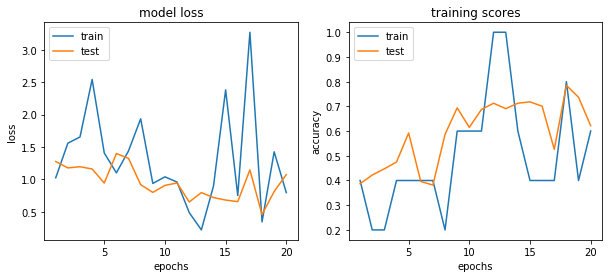

tensor([[ 5.,  3.,  5.,  1.],
        [ 1.,  3.,  5.,  5.],
        [ 1.,  1.,  4.,  0.],
        [ 6.,  2., 16.,  8.]])

Valid set (66 samples): Average loss: 2.5236, Accuracy: 30.30%

Epoch: 0

Test set (921 samples): Average loss: 1.2886, Accuracy: 41.69%

Epoch 1 model saved!
Epoch: 1

Test set (921 samples): Average loss: 1.2553, Accuracy: 48.64%

Epoch 2 model saved!
Epoch: 2

Test set (921 samples): Average loss: 1.3395, Accuracy: 36.05%

Epoch 3 model saved!
Epoch: 3

Test set (921 samples): Average loss: 1.1329, Accuracy: 46.91%

Epoch 4 model saved!
Epoch: 4

Test set (921 samples): Average loss: 1.5393, Accuracy: 30.40%

Epoch 5 model saved!
Epoch: 5

Test set (921 samples): Average loss: 1.0458, Accuracy: 54.29%

Epoch 6 model saved!
Epoch: 6

Test set (921 samples): Average loss: 1.1920, Accuracy: 43.97%

Epoch 7 model saved!
Epoch: 7

Test set (921 samples): Average loss: 0.9984, Accuracy: 56.89%

Epoch 8 model saved!
Epoch: 8

Test set (921 samples): Average loss: 1.2852

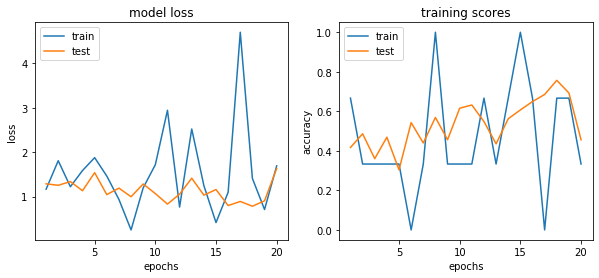

tensor([[12.,  0.,  0.,  5.],
        [ 7.,  1.,  0.,  0.],
        [ 3.,  1.,  1.,  1.],
        [15.,  2.,  2., 16.]])

Valid set (66 samples): Average loss: 1.6915, Accuracy: 45.45%

Epoch: 0

Test set (924 samples): Average loss: 1.1880, Accuracy: 45.35%

Epoch 1 model saved!
Epoch: 1

Test set (924 samples): Average loss: 1.2784, Accuracy: 43.07%

Epoch 2 model saved!
Epoch: 2

Test set (924 samples): Average loss: 1.0236, Accuracy: 50.43%

Epoch 3 model saved!
Epoch: 3

Test set (924 samples): Average loss: 1.1276, Accuracy: 56.49%

Epoch 4 model saved!
Epoch: 4

Test set (924 samples): Average loss: 0.8671, Accuracy: 56.60%

Epoch 5 model saved!
Epoch: 5

Test set (924 samples): Average loss: 0.9479, Accuracy: 54.65%

Epoch 6 model saved!
Epoch: 6

Test set (924 samples): Average loss: 0.8489, Accuracy: 62.12%

Epoch 7 model saved!
Epoch: 7

Test set (924 samples): Average loss: 0.8628, Accuracy: 61.58%

Epoch 8 model saved!
Epoch: 8

Test set (924 samples): Average loss: 0.6591

KeyboardInterrupt: 

In [14]:
batch_size = [40,20,20]
seleframe = [11,13,15]
max_lr = [2.6e-3,2.6e-3,2e-3]

#create a log
title = mkdir(Logpath)

for s,b,l in zip(seleframe, batch_size,max_lr):
    #create parameters
    params = {'batch_size': b, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    params_vali = {'batch_size': batch_vali, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}      
    for v in range(k):        
        valid_score = TrainingModel(v,s,b,l,title, params, params_vali,item)
        item += 1


In [ ]:
print(Logpath,title)